# K-Nearest Neighbors Model

### Imports

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import shap
import xgboost as xgb
import sklearn
from sklearn.preprocessing import OneHotEncoder

## Import data and identify catagorical varables

In [82]:
raw_data = pd.read_csv('../../normalized_data.csv')
raw_data2 = pd.read_csv('../../rodpump_noImputed.csv')

In [83]:
categorical_columns = ['bha_configuration',
                      'wellbore_category',
                       'packer_vs_tac',
                       'rod_sinker_type',
                       'manual_scale',
                       'rod_make',
                       'rod_apigrade',
#                        'DESANDDEGAS_TYP',
                       'rod_has_guides',
                       'pump_bore'
                      ]

In [84]:
from sklearn import preprocessing

# 1. INSTANTIATE
# encode labels with value between 0 and n_classes-1.
le = preprocessing.LabelEncoder()

# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
raw_data[categorical_columns] = raw_data[categorical_columns].apply(le.fit_transform)
raw_data2[categorical_columns] = raw_data2[categorical_columns].apply(le.fit_transform)

# # 1. INSTANTIATE
# enc = preprocessing.OneHotEncoder()

# # 2. FIT
# raw_data['bha_configuration'] = enc.fit(raw_data)

# # 3. Transform
# raw_data['bha_configuration'] = enc.transform(raw_data).toarray()

# print(raw_data)


## Encode catagorical variables

In [85]:
def encode(df, column):
    enc = OneHotEncoder()
    df[column] = enc.fit_transform(df[column].values.reshape(-1,1)).toarray()
    return df

In [86]:
# for column in raw_data:
#     if (column in categorical_columns):
#         raw_data = encode(raw_data, column)
        
#print(raw_data['bha_configuration'])

## Creating and normalizing test-train data

In [87]:
features = list(raw_data)
features.remove('FAILURETYPE')
features.remove('roduid')
features.remove('UWI')
#remove lifetime_end only for rodpump_noImputed dataset
#features.remove('lifetime_end')
#features.remove('pump_bore')
features.remove('contains_imputed')

#define x and y dataset (train/ test data)
X_train = raw_data[features]
y_train = raw_data['FAILURETYPE']


features = list(raw_data2)
features.remove('FAILURETYPE')
features.remove('roduid')
features.remove('UWI')
#remove lifetime_end only for rodpump_noImputed dataset
features.remove('lifetime_end')
#features.remove('pump_bore')
features.remove('contains_imputed')

#define x and y dataset (train/ test data)
X_test = raw_data2[features]
y_test = raw_data2['FAILURETYPE']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=30)

#scaling/normalizing
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)




## Finding best K value to use for model

In [88]:
error = []
for i in range(1, 80):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

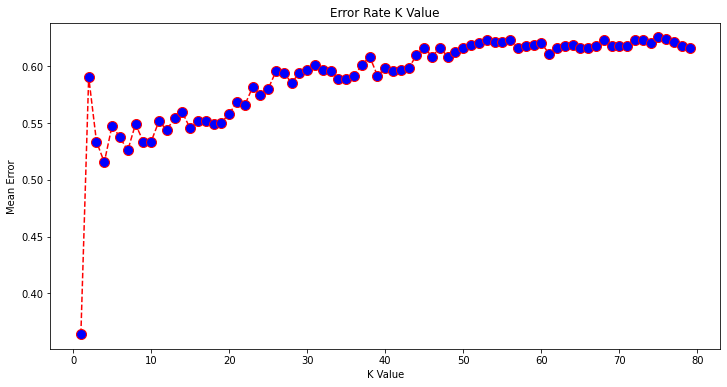

In [89]:

plt.figure(figsize=(12, 6))
plt.plot(range(1, 80), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

## Training the model and finding the accuracy with the best K-value

In [90]:
best_k = 0
best_metric = 0
for i in range(1, 40):
    n_neighbors=i
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    
    if metrics.accuracy_score(y_test, pred_i) > best_metric:
        best_k = n_neighbors
        best_metric =  metrics.accuracy_score(y_test, pred_i)
       

In [91]:
knn = KNeighborsClassifier(best_k)
knn.fit(X_train, y_train)
pred_i = knn.predict(X_test)
confus_matrix = confusion_matrix(y_test, pred_i)
print(confus_matrix)
print(classification_report(y_test, pred_i))

[[120   0   0]
 [ 34 122  27]
 [127  94 250]]
                 precision    recall  f1-score   support

           Rods       0.43      1.00      0.60       120
Sucker Rod Pump       0.56      0.67      0.61       183
         Tubing       0.90      0.53      0.67       471

       accuracy                           0.64       774
      macro avg       0.63      0.73      0.63       774
   weighted avg       0.75      0.64      0.64       774



- Accuracy = # of correct predictions over total predictions
- Precision = # correctly positively identified classifiactions over total positive identifications (True positives  over True positives + False Positives)
- Recall = # of actual postives identified correctly (True positives over true positives + false negatives), want this to generally be close to 1.00
- F1-score = the harmonic mean of precision and recall, preciseness of model
- Support = total number test cases

## Confusion Matrix and Accuracy Score

The best accuracy of the KNN model unsing a K value of 1 is: 0.6356589147286822


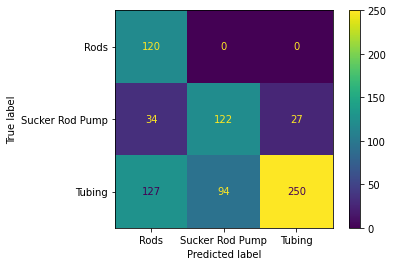

In [92]:
plot_confusion_matrix(knn, X_test, y_test)
print("The best accuracy of the KNN model unsing a K value of " + str(best_k) +" is: " + str(best_metric))

Cross Validation Score: 0.5132823698041089


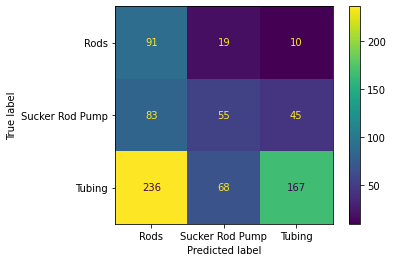

In [93]:
#create new a knn model
knn2 = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 40)}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

#fit model to data
knn2model = knn_gscv.fit(X_train, y_train)

#check top performing n_neighbors value
knn_gscv.best_params_

#confusion matrix
plot_confusion_matrix(knn_gscv,X_test,y_test)

#check mean score for the top performing value of n_neighbors
print("Cross Validation Score: " + str(knn_gscv.best_score_))

In [94]:
shap.initjs()

X_train = raw_data[features]
encode(raw_data, 'FAILURETYPE')
y_train = raw_data['FAILURETYPE']
X_test = raw_data2[features]
encode(raw_data2, 'FAILURETYPE')
y_test = raw_data2['FAILURETYPE']
#X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=7)

dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
X_train_norm = X_train.copy()
X_valid_norm = X_valid.copy()
for k,dtype in dtypes:
    m = X_train[k].mean()
    s = X_train[k].std()
    X_train_norm[k] -= m
    X_train_norm[k] /= s

    X_valid_norm[k] -= m
    X_valid_norm[k] /= s

#knn_norm = sklearn.neighbors.KNeighborsClassifier()
knn2model.fit(X_train_norm, y_train)

f = lambda x: knn2model.predict_proba(x)[:,1]
med = X_train_norm.median().values.reshape((1,X_train_norm.shape[1]))
explainer = shap.KernelExplainer(f, med)
shap_values_norm = explainer.shap_values(X_valid_norm.iloc[0:1000,:], nsamples=1000)
shap.force_plot(explainer.expected_value, shap_values_norm, X_valid.iloc[0:1000,:])

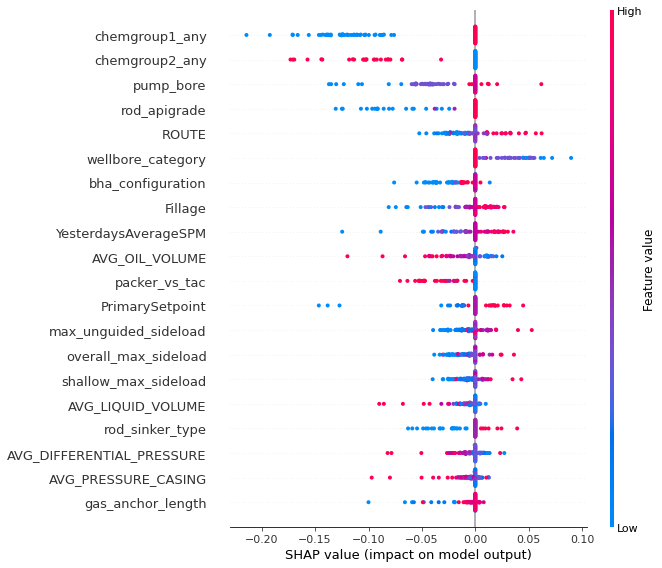

In [98]:
shap.summary_plot(shap_values_norm, X_valid)

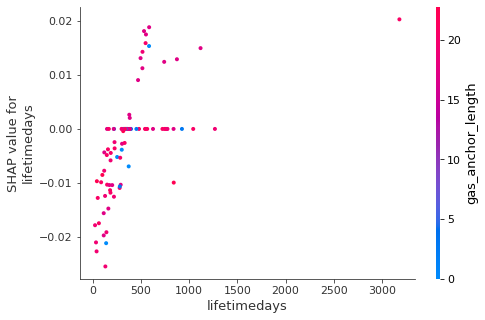

In [96]:
shap.dependence_plot("lifetimedays", shap_values_norm, X_valid.iloc[0:1000,:])